## Setup

In [ ]:
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu121

!pip install -U openmim
!mim install mmengine
!mim install mmcv==2.1.0
!mim install mmdet
!mim install mmpose

Looking in indexes: https://download.pytorch.org/whl/cu121
Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.1.0/index.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.1.0/index.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.1.0/index.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.1.0/index.html


In [ ]:
!git clone https://github.com/open-mmlab/mmaction2.git
%cd mmaction2
!pip install -v -e .

fatal: destination path 'mmaction2' already exists and is not an empty directory.
/content/mmaction2
Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
Obtaining file:///content/mmaction2
  Running command python setup.py egg_info
  running egg_info
  creating /tmp/pip-pip-egg-info-maqoyw4s/mmaction2.egg-info
  writing manifest file '/tmp/pip-pip-egg-info-maqoyw4s/mmaction2.egg-info/SOURCES.txt'
  writing manifest file '/tmp/pip-pip-egg-info-maqoyw4s/mmaction2.egg-info/SOURCES.txt'
  Preparing metadata (setup.py) ... done
  Attempting uninstall: mmaction2
    Found existing installation: mmaction2 1.2.0
    Uninstalling mmaction2-1.2.0:
      Removing file or directory /usr/local/lib/python3.10/dist-packages/mmaction2.egg-link
      Removing pth entries from /usr/local/lib/python3.10/dist-packages/easy-install.pth:
      Removing entry: /content/mmaction2
      Successfully uninstalled mmaction2-1.2.0
  Running setup.py develop for mmaction2
    Running com

In [ ]:
!pip install timm

## Training pretrained TSN model

In [ ]:
!python tools/train.py ../drive/MyDrive/pretrained/configs/pretrained_tsn_config.py --seed=0 --work-dir=/content/drive/MyDrive/pretrained/tsn

06/17 09:06:51 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.2, V12.2.140
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.1.0+cu121
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-ge

## Testing model

In [ ]:
!python tools/test.py /content/drive/MyDrive/pretrained/configs/pretrained_tsn_config.py /content/drive/MyDrive/pretrained/tsn/best_acc_top1_epoch_47.pth

06/17 09:28:13 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1292320892
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.2, V12.2.140
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.1.0+cu121
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=

In [ ]:
# Copyright (c) OpenMMLab. All rights reserved.
import logging
import tempfile
import torch

from mmengine import dump, list_from_file, load
from mmengine.config import Config, DictAction
from mmengine.evaluator import Evaluator
from mmengine.runner import Runner

from mmaction.evaluation import ConfusionMatrix
from mmaction.registry import DATASETS
from mmaction.utils import register_all_modules


def eval_checkpoint(
    config_path,
    ckpt_or_result,
    output=None,
    show=False,
    show_path=None,
    include_values=False,
    label_file=None,
    target_classes=[],
    cmap='viridis',
    cfg_options=None
):
    # register all modules in mmaction into the registries
    # do not init the default scope here because it will be init in the runner
    register_all_modules(init_default_scope=False)

    # load config
    cfg = Config.fromfile(config_path)
    if cfg_options is not None:
        cfg.merge_from_dict(cfg_options)

    if ckpt_or_result.endswith('.pth'):
        # Set confusion matrix as the metric.
        cfg.test_evaluator = dict(type='ConfusionMatrix')

        cfg.load_from = str(ckpt_or_result)

        with tempfile.TemporaryDirectory() as tmpdir:
            cfg.work_dir = tmpdir
            runner = Runner.from_cfg(cfg)
            classes = runner.test_loop.dataloader.dataset.metainfo.get(
                'classes')
            cm = runner.test()['confusion_matrix/result']
            logging.shutdown()
    else:
        predictions = load(ckpt_or_result)
        evaluator = Evaluator(ConfusionMatrix())
        metrics = evaluator.offline_evaluate(predictions, None)
        cm = metrics['confusion_matrix/result']
        try:
            # Try to build the dataset.
            dataset = DATASETS.build({
                **cfg.test_dataloader.dataset, 'pipeline': []
            })
            classes = dataset.metainfo.get('classes')
        except Exception:
            classes = None

    if label_file is not None:
        classes = list_from_file(label_file)
    if classes is None:
        num_classes = cm.shape[0]
        classes = list(range(num_classes))

    if target_classes:
        assert len(target_classes) > 1, \
            'please ensure select more than one class'
        target_idx = torch.tensor(target_classes)
        cm = cm[target_idx][:, target_idx]
        classes = [classes[idx] for idx in target_idx]

    if output is not None:
        dump(cm, output)

    if show or show_path is not None:
        fig = ConfusionMatrix.plot(
            cm,
            show=show,
            classes=classes,
            include_values=include_values,
            cmap=cmap)
        if show_path is not None:
            fig.savefig(show_path)
            print(f'The confusion matrix is saved at {show_path}.')


eval_checkpoint(
    config_path="/content/drive/MyDrive/pretrained/configs/pretrained_tsn_config.py",
    ckpt_or_result='/content/drive/MyDrive/pretrained/tsn/best_acc_top1_epoch_47.pth',
    output="./results/posec3d/visualizations.png",
    show=True,
    show_path="../../results/posec3d/visualizations.png",
    include_values=True,
)


06/17 09:29:32 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1785782699
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.2, V12.2.140
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.1.0+cu121
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loads checkpoint by local backend from path: /content/drive/MyDrive/pretrained/tsn/best_acc_top1_epoch_47.pth
06/17 09:29:34 - mmengine - INFO - Load checkpoint from /content/drive/MyDrive/pretrained/tsn/best_acc_top1_epoch_47.pth


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


06/17 09:29:34 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
06/17 09:29:34 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
06/17 09:29:34 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
06/17 09:29:34 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
06/17 09:29:34 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
06/17 09:29:34 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
06/17 09:29:34 - mmengine - WARNING - "FileClient" will be deprecated in future. P

TypeError: Unsupported format: png

incorrect: 11
total: 62


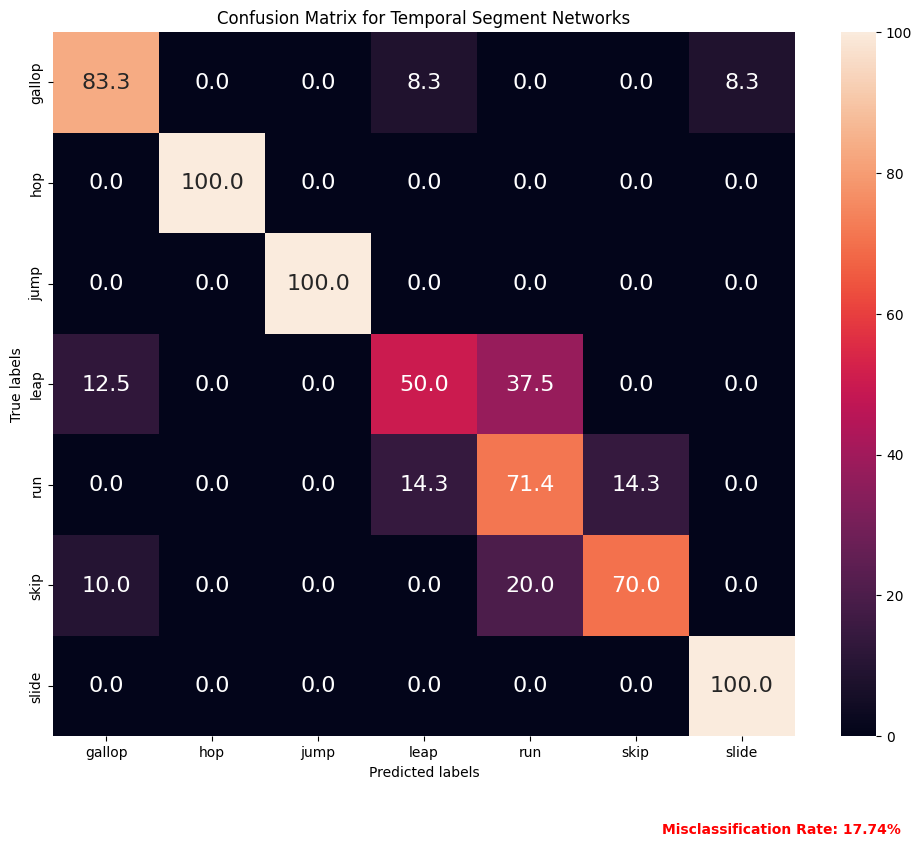

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Given tensor
tensor = torch.tensor([[10,  0,  0,  1,  0,  0,  1],
        [ 0,  5,  0,  0,  0,  0,  0],
        [ 0,  0,  2,  0,  0,  0,  0],
        [ 1,  0,  0,  4,  3,  0,  0],
        [ 0,  0,  0,  1,  5,  1,  0],
        [ 1,  0,  0,  0,  2,  7,  0],
        [ 0,  0,  0,  0,  0,  0, 18]])

# Convert tensor to numpy array
cm = tensor.numpy()

# Calculate row sums
row_sums = cm.sum(axis=1, keepdims=True)

# Convert counts to percentages
cm_percentages = cm / row_sums.astype(float) * 100

# Calculate misclassification rate

incorrect = np.sum(cm) - np.sum(np.diag(cm))
total = np.sum(cm)
misclassification_rate = incorrect / total * 100
print(f"incorrect: {incorrect}")
print(f"total: {total}")

# Define class names
CLASS_NAMES = {
    "gallop": 0,
    "hop": 1,
    "jump": 2,
    "leap": 3,
    "run": 4,
    "skip": 5,
    "slide": 6,
}

# Get class labels for axis
class_labels = [k for k in CLASS_NAMES.keys()]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
# sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_percentages, annot=True, fmt='.1f', cmap='rocket', annot_kws={"size": 16},
            xticklabels=class_labels, yticklabels=class_labels)  # font size
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Temporal Segment Networks')
plt.tight_layout()
plt.text(8, 8, f'Misclassification Rate: {misclassification_rate:.2f}%', horizontalalignment='right', verticalalignment='bottom', fontdict={"size": 10, "weight": "bold", "color":"red"})
plt.show()


In [ ]:
import argparse

from mmengine import Config
from mmengine.registry import init_default_scope

from mmaction.registry import MODELS

try:
    from mmengine.analysis import get_model_complexity_info
except ImportError:
    raise ImportError('Please upgrade mmcv to >0.6.2')


def get_model_complexity(config_path, input_shape=(224, 224)):
    if len(input_shape) == 1:
        input_shape = (1, 3, input_shape[0], input_shape[0])
    elif len(input_shape) == 2:
        input_shape = (1, 3) + tuple(input_shape)
    elif len(input_shape) == 4:
        input_shape = tuple(input_shape)
    elif len(input_shape) == 5:
        input_shape = tuple(input_shape)
    else:
        raise ValueError('invalid input shape')

    cfg = Config.fromfile(config_path)
    init_default_scope(cfg.get('default_scope', 'mmaction'))
    model = MODELS.build(cfg.model)
    model.eval()

    if hasattr(model, 'extract_feat'):
        model.forward = model.extract_feat
    else:
        raise NotImplementedError(
            'FLOPs counter is currently not currently supported with {}'.
            format(model.__class__.__name__))

    analysis_results = get_model_complexity_info(model, input_shape)
    flops = analysis_results['flops_str']
    params = analysis_results['params_str']
    table = analysis_results['out_table']
    print(table)
    split_line = '=' * 30
    print(f'\n{split_line}\nInput shape: {input_shape}\n'
          f'Flops: {flops}\nParams: {params}\n{split_line}')
    print('!!!Please be cautious if you use the results in papers. '
          'You may need to check if all ops are supported and verify that the '
          'flops computation is correct.')


# Example usage in a notebook:
config_path = '/content/drive/MyDrive/pretrained/configs/pretrained_tsn_config.py'
input_shape = (1, 3, 224, 224)  # or any other input shape you want to use
get_model_complexity(config_path, input_shape)


06/17 09:47:40 - mmengine - WARNING - Unsupported operator aten::max_pool2d encountered 1 time(s)
06/17 09:47:40 - mmengine - WARNING - Unsupported operator aten::add encountered 16 time(s)
06/17 09:47:40 - mmengine - WARNING - The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
cls_head, cls_head.avg_pool, cls_head.consensus, cls_head.dropout, cls_head.fc_cls, cls_head.loss_cls, data_preprocessor
06/17 09:47:41 - mmengine - WARNING - Unsupported operator aten::batch_norm encountered 53 time(s)



+--------------------------+----------------------+-----------+--------------+
| module                   | #parameters or shape | #flops    | #activations |
+--------------------------+----------------------+-----------+--------------+
| model                    | 23.522M              | 4.109G    | 11.114M      |
|  backbone                |  23.508M             |  4.109G   |  11.114M     |
|   backbone.conv1         |   9.536K             |   0.12G   |   0.803M     |
|    backbone.conv1.conv   |    9.408K            |    0.118G |    0.803M    |
|    backbone.conv1.bn     |    0.128K            |    1.606M |    0         |
|   backbone.layer1        |   0.216M             |   0.677G  |   4.415M     |
|    backbone.layer1.0     |    75.008K           |    0.235G |    2.007M    |
|    backbone.layer1.1     |    70.4K             |    0.221G |    1.204M    |
|    backbone.layer1.2     |    70.4K             |    0.221G |    1.204M    |
|   backbone.layer2        |   1.22M              |

In [ ]:
import os

model_size = os.path.getsize("/content/drive/MyDrive/pretrained/tsn/best_acc_top1_epoch_47.pth") / 1000000

print(f"Temporal Segment Network Model Size: {model_size} MB")

Temporal Segment Network Model Size: 94.659378 MB


Running inference

In [2]:
from moviepy.editor import VideoFileClip
import tempfile
import torch
from preprocessing.pose_keypoint import pose_inference_with_align
import cv2
from pathlib import Path
from constants import globals as g
from mmaction.apis import (
    detection_inference,
)
from utils import settings
from mmaction.utils import frame_extract

%load_ext autoreload
%autoreload 2

tmp_dir = tempfile.TemporaryDirectory()

def clipped_one_sec(video_path) -> str:
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise ValueError(f"Could not open: {video_path}")

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    duration = total_frames / fps

    start_time = (duration / 2) - 0.5
    start_frame = int(start_time * fps)

    frames = []
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    for _ in range(fps):
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    cap.release()

    clip_path = f"{tmp_dir.name}/1-sec-clip.mp4"
    out = cv2.VideoWriter(
        clip_path,
        cv2.VideoWriter_fourcc(*"mp4v"),
        fps,
        (
            frames[0].shape[1],
            frames[0].shape[0],
        ),
    )

    for frame in frames:
        out.write(frame)

    out.release()
    return clip_path

def center_crop(input_path, aspect_ratio=(4, 3)):
    video = VideoFileClip(str(input_path))

    original_width, original_height = video.size

    target_width, target_height = aspect_ratio
    new_height = original_width * target_height / target_width

    if new_height > original_height:
        new_height = original_height
        new_width = new_height * target_width / target_height
    else:
        new_width = original_width

    x_center = original_width / 2
    y_center = original_height / 2
    crop_x1 = x_center - new_width / 2
    crop_x2 = x_center + new_width / 2
    crop_y1 = y_center - new_height / 2
    crop_y2 = y_center + new_height / 2

    cropped_video = video.crop(x1=crop_x1, y1=crop_y1, x2=crop_x2, y2=crop_y2)

    with tempfile.NamedTemporaryFile(delete=False, suffix='.mp4') as temp_file:
        temp_file_path = temp_file.name
    
    cropped_video.write_videofile(temp_file_path)

    return temp_file_path


if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

filename = "hop-trial.mp4"
src_vid = Path(g.TEST_DATA_DIR, filename)
src_cropped = center_crop(src_vid)
src_clipped_vid = clipped_one_sec(src_cropped)

frame_paths, frames = frame_extract(
    src_clipped_vid,
    out_dir=tmp_dir.name,
    short_side=1080
)

torch.cuda.empty_cache()
det_results, _ = detection_inference(
    det_config=settings.det_config,
    det_checkpoint=settings.det_checkpoint,
    det_score_thr=settings.det_score_thr,
    frame_paths=frame_paths,
    device=device,
    with_score=True
)
keypoints, scores = pose_inference_with_align(frame_paths, det_results)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Moviepy - Building video C:\Users\nepom\AppData\Local\Temp\tmpticbd6cb.mp4.
Moviepy - Writing video C:\Users\nepom\AppData\Local\Temp\tmpticbd6cb.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\nepom\AppData\Local\Temp\tmpticbd6cb.mp4
06/18 00:15:11 - mmengine - WARNING - The current default scope "mmpose" is not "mmdet", `init_default_scope` will force set the currentdefault scope to "mmdet".
Loads checkpoint by local backend from path: C:\Users\nepom\Downloads\gm-activity-recognition\models\faster_rcnn_r50_fpn_1x_coco-person_20201216_175929-d022e227.pth
Performing Human Detection for each frame
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 30/30, 12.6 task/s, elapsed: 2s, ETA:     0s
06/18 00:15:14 - mmengine - WARNING - The current default scope "mmdet" is not "mmpose", `init_default_scope` will force set the currentdefault scope to "mmpose".
Loads checkpoint by local backend from path: C:\Users\nepom\Downloads\gm-activity-recognition\models\hrnet_w32_coco_256x192-c78dce93_20200708.pth
Performing Human Pose Estimation for each frame
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 30/30, 7.2 task/s, elapsed: 4s, ETA:     0s


In [3]:
frames[0].shape[:2]

(1080, 1440)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import io
import tempfile
from scipy.ndimage import gaussian_filter
from PIL import Image
import imageio
from pathlib import Path

def create_heatmap_gif(keypoints, target_frames):
    frames = []

    for frame_index in range(len(target_frames)):
        heatmap = np.zeros(target_frames[frame_index].shape[:2])
        spread = 10

        for joint in keypoints[frame_index]:
            x, y = int(joint[0]), int(joint[1])
            if 0 <= x < heatmap.shape[1] and 0 <= y < heatmap.shape[0]:
                heatmap[y, x] = 1

        heatmap_blurred = gaussian_filter(heatmap, sigma=spread)
        heatmap_normalized = heatmap_blurred / heatmap_blurred.max()

        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(heatmap_normalized, interpolation="nearest")
        ax.axis("off")

        # Save the frame to a buffer
        buf = io.BytesIO()
        plt.savefig(buf, format="png", bbox_inches="tight", pad_inches=0)
        buf.seek(0)
        plt.close(fig)

        # Resize the image to 224x224
        image = Image.open(buf)
        image = image.resize((224, 224), Image.Resampling.LANCZOS)
        frames.append(np.array(image))

    # Create a temporary file to save the GIF
    with tempfile.NamedTemporaryFile(delete=False, suffix=".gif") as temp_file:
        temp_file_path = temp_file.name

    # Save the frames as a GIF in the temporary file
    imageio.mimsave(temp_file_path, frames, duration=1)

    return temp_file_path

In [20]:
input_src = create_heatmap_gif(keypoints[1, :], frames)

342.90857 175.30699
342.90857 168.22073
321.6498 168.22073
342.90857 161.13448
279.1323 168.22073
349.9948 246.16953
236.61478 260.34204
364.16733 345.37708
201.18352 373.72208
385.4261 430.4121
222.44228 487.10214
349.9948 472.92963
286.21857 480.01587
349.9948 614.65466
300.39105 614.65466
342.90857 749.2935
286.21857 763.466
912.03296 348.12213
924.263 335.89206
893.68787 335.89206
936.49304 335.89206
869.2277 335.89206
954.83813 403.15738
844.76764 421.50244
967.0682 464.30765
820.3075 519.3429
973.1832 519.3429
844.76764 611.0683
948.7231 598.83826
881.45776 604.95325
960.9531 721.1388
912.03296 721.1388
936.49304 788.40405
905.9179 837.3243
909.517 334.54718
921.9547 322.1095
890.86053 322.1095
934.3924 328.32834
865.98517 322.1095
953.04895 396.7356
834.8909 415.39212
965.48663 452.70517
810.01556 508.67474
971.70544 496.23706
841.1098 589.51965
946.8301 589.51965
878.42285 601.95734
959.26776 713.8965
903.2982 713.8965
934.3924 776.0849
903.2982 838.2733
321.51453 174.36913
321

In [52]:
from mmaction.apis import inference_recognizer, init_recognizer
import time

from operator import itemgetter
labels = ["gallop", "hop", "jump", "leap", "run", "skip", "slide"]


config_path = Path(g.PROJECT_DIR, 'configs/pretrained_tsn_config.py').__str__()
checkpoint_path = Path(g.PROJECT_DIR, "models/tsn-best.pth").__str__()

model = init_recognizer(config_path, checkpoint_path, device="cuda:0")

start = time.time()
result = inference_recognizer(model, input_src)
end = time.time()

pred_scores = result.pred_score.tolist()
score_tuples = tuple(zip(range(len(pred_scores)), pred_scores))
score_sorted = sorted(score_tuples, key=itemgetter(1), reverse=True)
top5_label = score_sorted[:5]

results = [(labels[k[0]], k[1]) for k in top5_label]
label, score = results[0]

elapsed = end - start
print(f"Elapsed inference time: {round(elapsed, 4)} seconds")
print(
    f"Predicted action: {label.upper()} with confidence score of {round((score*100), 4)}%."
)

Loads checkpoint by local backend from path: C:\Users\nepom\Downloads\gm-activity-recognition\models\tsn-best.pth
Elapsed inference time: 0.056 seconds
Predicted action: HOP with confidence score of 74.439%.


In [44]:
results[0][0]

'hop'

In [33]:
results

[('hop', 0.7466204166412354),
 ('slide', 0.2270798534154892),
 ('jump', 0.025993265211582184),
 ('gallop', 0.00015666146646253765),
 ('leap', 8.908774179872125e-05)]